Pré-processamento

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import seaborn as sns
from matplotlib import pyplot as plt
from collections import Counter
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering

import matplotlib.pyplot as plt


Leitura dos dados

In [2]:
breeds = pd.read_csv('https://raw.githubusercontent.com/tmfilho/akcdata/master/data/akc-data-latest.csv')

Verificar a existência de atributos que possuem muitas faltas de dados

In [3]:
linhas_com_valores_faltantes = breeds[breeds.isna().any(axis=1)]
print(linhas_com_valores_faltantes.isna().sum())

Unnamed: 0                      0
description                     0
temperament                     1
popularity                     79
min_height                      0
max_height                      0
min_weight                      2
max_weight                      2
min_expectancy                  3
max_expectancy                  3
group                           0
grooming_frequency_value        7
grooming_frequency_category     7
shedding_value                 20
shedding_category              20
energy_level_value              6
energy_level_category           6
trainability_value             24
trainability_category          24
demeanor_value                 25
demeanor_category              25
dtype: int64


Eliminação dos atribuitos popularity devido à sua quantidade de dados faltantes. As outras duas colunas não apresentavam tanta relevância para a construção do modelo, por isso foram retiradas

In [4]:
breeds.drop('description', axis=1, inplace=True)
breeds.drop('popularity', axis=1, inplace=True)
breeds.drop('Unnamed: 0', axis=1, inplace=True)

A baixo eliminamos linhas duplicadas, caso hajam e também verificamos como está o balanceamento entre as classes, que é o atributo "group" da nossa base. É possível verificar que existe um desbalanceamento entre os grupos. Por isso, ao selecionar os dados de treino e teste, iremos retirar uma amostragem estratificada, tentando minimizar o viés, o que não será tão efetivo, pois o desbalanceamento entre a maior classe e a menor é bem alto, bem como o a menor classe possui pouquíssimos dados.

In [5]:
breeds.drop_duplicates()

counts = breeds['group'].value_counts()
counts

group
Foundation Stock Service    68
Hound Group                 32
Sporting Group              32
Terrier Group               31
Working Group               31
Herding Group               30
Toy Group                   21
Non-Sporting Group          21
Miscellaneous Class         11
Name: count, dtype: int64

Aqui é feita a conversão dos valores dos atributos para o modo númerico.

In [6]:
le = preprocessing.LabelEncoder()

for column in breeds.columns:
  if breeds[column].dtypes == 'object':
    breeds[column] = le.fit_transform(breeds[column])

breeds

,temperament,min_height,max_height,min_weight,max_weight,min_expectancy,max_expectancy,group,grooming_frequency_value,grooming_frequency_category,shedding_value,shedding_category,energy_level_value,energy_level_category,trainability_value,trainability_category,demeanor_value,demeanor_category
0,78,22.86,29.21,3.175147,4.535924,12.0,15.0,7,0.6,0,0.6,4,0.6,4,0.8,2,1.0,3
1,102,63.50,68.58,22.679619,27.215542,12.0,15.0,2,0.8,1,0.2,1,0.8,2,0.2,4,0.2,1
2,131,58.42,58.42,22.679619,31.751466,11.0,14.0,6,0.6,0,0.4,2,0.6,4,1.0,1,0.8,2
3,92,60.96,71.12,31.751466,58.967008,10.0,13.0,8,0.8,1,0.6,4,0.8,2,1.0,1,0.6,0
4,31,58.42,63.50,34.019428,38.555351,10.0,14.0,8,0.6,0,0.6,4,0.8,2,0.4,3,0.8,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,172,54.61,63.50,20.411657,29.483504,12.0,14.0,5,0.2,2,0.6,4,0.8,2,0.6,0,0.6,0
273,50,48.26,63.50,12.700586,27.215542,12.0,15.0,0,0.2,2,0.6,4,0.8,2,0.4,3,0.6,0
274,202,25.40,58.42,4.535924,24.947580,13.0,18.0,4,0.2,2,0.2,1,0.8,2,0.6,0,0.6,0
275,22,53.34,58.42,18.143695,24.947580,10.0,12.0,0,0.4,4,0.6,4,0.8,2,0.2,4,0.4,4


Aqui agrupamos os dados de acordo ao grupo pertencente e preenchemos diversos valores faltantes de acordo com a média do grupo.

In [7]:
breeds = breeds.groupby('group').apply(lambda x: x.fillna(x.mean()))

breeds = breeds.reset_index(drop=True)


Checagem da correlação entre os atributos

In [8]:
correlacao = breeds.corr()

#matriz de correlação
correlacao.style.background_gradient(cmap='coolwarm')

,temperament,min_height,max_height,min_weight,max_weight,min_expectancy,max_expectancy,group,grooming_frequency_value,grooming_frequency_category,shedding_value,shedding_category,energy_level_value,energy_level_category,trainability_value,trainability_category,demeanor_value,demeanor_category
temperament,1.000000,0.054740,0.092223,0.048929,0.061609,0.068399,-0.017823,-0.100909,-0.031742,0.050721,0.014637,0.046369,0.030415,0.058106,-0.010526,-0.007208,-0.043370,-0.004169
min_height,0.054740,1.000000,0.935146,0.814239,0.791331,-0.458515,-0.462374,-0.132758,-0.192475,0.093308,0.284185,0.204192,0.173782,-0.195669,-0.052669,0.191184,-0.248545,0.021992
max_height,0.092223,0.935146,1.000000,0.791522,0.804788,-0.439959,-0.466256,-0.186988,-0.248314,0.123787,0.320869,0.216608,0.197728,-0.218828,-0.056881,0.207455,-0.303222,0.077013
min_weight,0.048929,0.814239,0.791522,1.000000,0.947534,-0.538031,-0.548036,-0.053277,-0.144710,0.041254,0.286939,0.193159,-0.069380,-0.210604,-0.127880,0.191313,-0.277545,0.054664
max_weight,0.061609,0.791331,0.804788,0.947534,1.000000,-0.511851,-0.520872,-0.051355,-0.123274,0.026933,0.284637,0.179967,-0.073512,-0.240826,-0.074718,0.144391,-0.270527,0.049763
min_expectancy,0.068399,-0.458515,-0.439959,-0.538031,-0.511851,1.000000,0.765366,-0.081172,0.033506,-0.050637,-0.249748,-0.103637,0.000525,0.042366,0.093669,-0.022883,0.183984,0.009060
max_expectancy,-0.017823,-0.462374,-0.466256,-0.548036,-0.520872,0.765366,1.000000,0.007228,0.133751,-0.044420,-0.354855,-0.188648,0.010926,0.117585,0.097979,-0.062591,0.180729,-0.025257
group,-0.100909,-0.132758,-0.186988,-0.053277,-0.051355,-0.081172,0.007228,1.000000,0.255250,-0.101570,-0.111148,-0.104685,0.002825,0.176690,0.070564,-0.289924,0.248475,-0.253894
grooming_frequency_value,-0.031742,-0.192475,-0.248314,-0.144710,-0.123274,0.033506,0.133751,0.255250,1.000000,-0.311825,-0.072736,-0.091476,-0.148369,0.171126,0.102241,-0.066071,0.129083,0.037211
grooming_frequency_category,0.050721,0.093308,0.123787,0.041254,0.026933,-0.050637,-0.044420,-0.101570,-0.311825,1.000000,0.089542,0.115978,0.148883,0.047889,0.048884,0.038271,0.008180,0.085273


Redução de dimensionalidade utilizando o PCA, reduzindo o conjunto para apenas duas dimensões

In [9]:
pca = PCA(n_components=2) #Redução p/ 2 dimensões
principalComponents = pca.fit_transform(breeds)

breeds_pca = pd.DataFrame(data = principalComponents, columns = ['D1', 'D2'])

finalDf = pd.concat([breeds_pca, breeds[['group']]], axis = 1)

finalDf


,D1,D2,group
0,-96.544002,20.414935,0
1,-125.364761,11.986840,0
2,88.843702,10.430463,0
3,-69.924535,1.417412,0
4,77.288680,-4.701889,0
...,...,...,...
272,-107.861597,66.606391,8
273,131.870792,9.893730,8
274,-94.009331,2.697099,8
275,13.333777,-5.873375,8


Divisão dos conjuntos para treino e teste para os dados sem a redução de dimensionalidade

**Nessa primeira parte apenas serão os dados sem a redução de dimensionalidade**

In [10]:
X = breeds.drop('group', axis=1)
y = breeds['group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



Aplicação do algoritmo da árvore de decisão

Acurácia: 0.6071428571428571
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.68      0.93      0.79        14
           1       0.60      0.38      0.46         8
           2       0.57      0.80      0.67         5
           4       0.00      0.00      0.00         5
           5       0.40      0.40      0.40         5
           6       0.40      0.67      0.50         6
           7       1.00      0.80      0.89         5
           8       1.00      0.50      0.67         8

    accuracy                           0.61        56
   macro avg       0.58      0.56      0.55        56
weighted avg       0.62      0.61      0.59        56



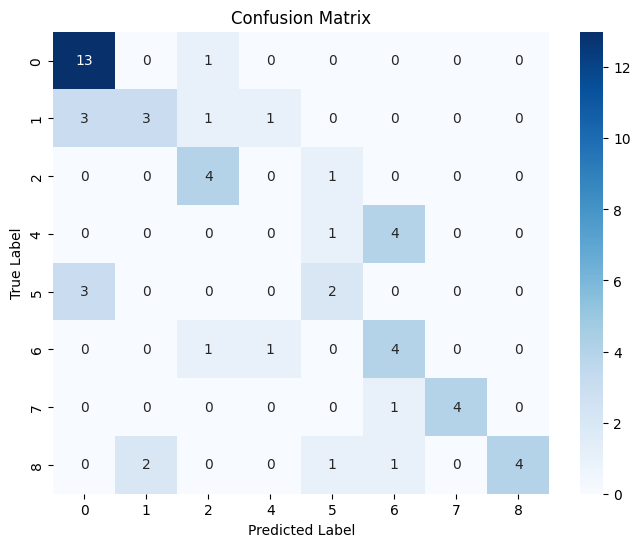

In [11]:
arvore = RandomForestClassifier(n_estimators=100, random_state=42)

#Treinamento da árvore de decisão
arvore.fit(X_train, y_train)

#Previsão
y_pred_arvore = arvore.predict(X_test)
acuracia = accuracy_score(y_test, y_pred_arvore)
print("Acurácia:", acuracia)

print("Relatório de Classificação:")
print(classification_report(y_test, y_pred_arvore))


#matriz de confusão
cm = confusion_matrix(y_test, y_pred_arvore)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=sorted(y_test.unique()), yticklabels=sorted(y_test.unique()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Aplicação do algoritmo do Naive Bayes

Acurácia: 0.48214285714285715
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.75      0.64      0.69        14
           1       0.00      0.00      0.00         8
           2       0.40      0.40      0.40         5
           3       0.00      0.00      0.00         0
           4       0.50      0.40      0.44         5
           5       0.27      0.60      0.37         5
           6       0.67      0.33      0.44         6
           7       0.50      0.80      0.62         5
           8       0.56      0.62      0.59         8

    accuracy                           0.48        56
   macro avg       0.40      0.42      0.40        56
weighted avg       0.49      0.48      0.47        56



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


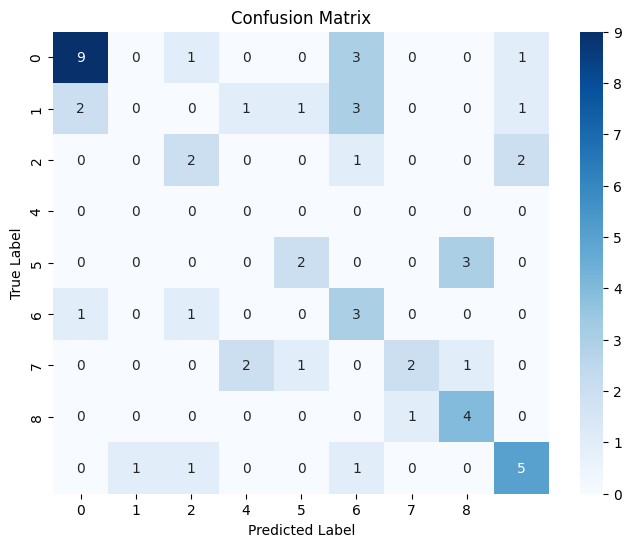

In [12]:
bayes = GaussianNB()

#Treinamento do Naive Bayes
bayes.fit(X_train, y_train)

#Previsão
y_pred_bayes = bayes.predict(X_test)
acuracia = accuracy_score(y_test, y_pred_bayes)
print("Acurácia:", acuracia)

print("Relatório de Classificação:")
print(classification_report(y_test, y_pred_bayes))

#matriz de confusão
cm = confusion_matrix(y_test, y_pred_bayes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=sorted(y_test.unique()), yticklabels=sorted(y_test.unique()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



Aplicação do algoritmo ao modelo de MLP. Iremos utilizar os valores normalizados

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Acurácia: 0.4642857142857143
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.45      0.71      0.56        14
           1       0.33      0.12      0.18         8
           2       0.60      0.60      0.60         5
           4       0.50      0.20      0.29         5
           5       0.29      0.40      0.33         5
           6       0.50      0.67      0.57         6
           7       0.50      0.40      0.44         5
           8       0.60      0.38      0.46         8

    accuracy                           0.46        56
   macro avg       0.47      0.44      0.43        56
weighted avg       0.47      0.46      0.44        56



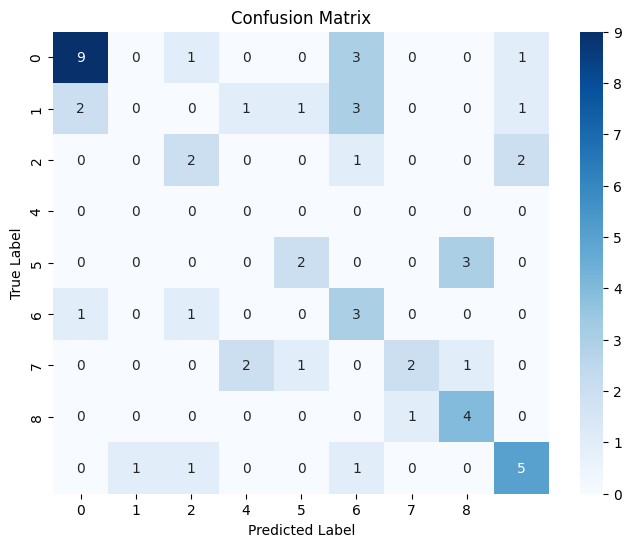

In [13]:
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

mlp = MLPClassifier(hidden_layer_sizes=(100,), random_state=42)

#MLP
mlp.fit(X_train, y_train)

#previsão
y_pred_mlp = mlp.predict(X_test)

acuracia = accuracy_score(y_test, y_pred_mlp)
print("Acurácia:", acuracia)

print("Relatório de Classificação:")
print(classification_report(y_test, y_pred_mlp))

#matriz de confusão
cm = confusion_matrix(y_test, y_pred_bayes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=sorted(y_test.unique()), yticklabels=sorted(y_test.unique()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()




As maiores métricas obtidas vieram através da árvore de decisão, que ainda assim não apresentou um resultado tão bom, ficando próximo aos 0.6 de acurácia.

O desbalanceamento entre os grupos e a baixa quantidade de dados com certeza contribuem bastante para resultados baixos nas métricas observadas. É possível observar também, através da matriz de confusão que curiosamente, as maiores taxas de acerto vieram do grupo com maior quantidade de instâncias e do grupo com menor quantidade. Talvez existam atributos que possam representar melhor os grupos escolhidos, pois, ao observar a correlação entre os atributos e o target (o atributo "group") é possível notar a baixa correlação entre eles, o que pode nos ajudar à começar a olhar e coletar outros atributos, além de coletar mais dados, para melhorarmos os modelos.

Claro que, somado a isso, os modelos e até o pré-processamento utilizado foram simples e sem a adoção de validação cruzada, ou mesmo oversampling para aumentarmos a base.




_______________________________________________________________________

**Agora testaremos com os dados após a redução de dimensionalidade**

In [14]:
X = finalDf.drop('group', axis=1)
y = finalDf['group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Árvore de decisão + PCA

Acurácia: 0.30357142857142855
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.39      0.50      0.44        14
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         5
           5       0.25      0.20      0.22         5
           6       0.33      0.50      0.40         6
           7       0.33      0.20      0.25         5
           8       0.38      0.62      0.48         8

    accuracy                           0.30        56
   macro avg       0.21      0.25      0.22        56
weighted avg       0.24      0.30      0.26        56



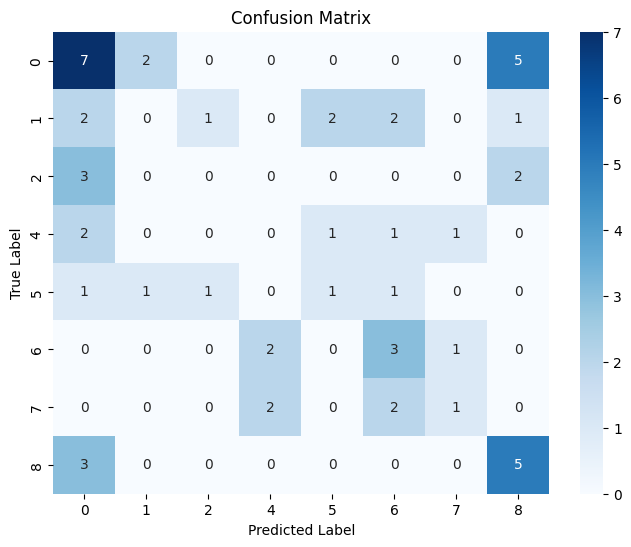

In [15]:
arvore = RandomForestClassifier(n_estimators=100, random_state=42)

#Treinamento da árvore de decisão
arvore.fit(X_train, y_train)

#Previsão
y_pred_arvore = arvore.predict(X_test)
acuracia = accuracy_score(y_test, y_pred_arvore)
print("Acurácia:", acuracia)

print("Relatório de Classificação:")
print(classification_report(y_test, y_pred_arvore))


#matriz de confusão
cm = confusion_matrix(y_test, y_pred_arvore)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=sorted(y_test.unique()), yticklabels=sorted(y_test.unique()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Naive Bayes + PCA

Acurácia: 0.30357142857142855
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.27      0.50      0.35        14
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         5
           5       0.29      0.40      0.33         5
           6       0.33      0.33      0.33         6
           7       0.44      0.80      0.57         5
           8       0.25      0.25      0.25         8

    accuracy                           0.30        56
   macro avg       0.20      0.29      0.23        56
weighted avg       0.20      0.30      0.24        56



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


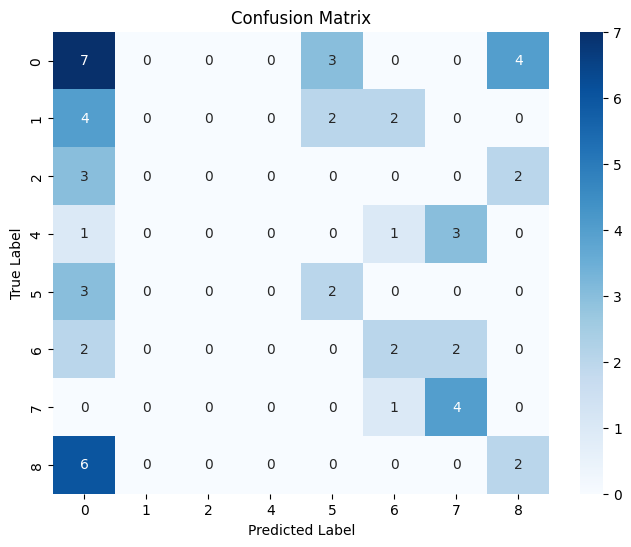

In [16]:
bayes = GaussianNB()

#Treinamento do Naive Bayes
bayes.fit(X_train, y_train)

#Previsão
y_pred_bayes = bayes.predict(X_test)
acuracia = accuracy_score(y_test, y_pred_bayes)
print("Acurácia:", acuracia)

print("Relatório de Classificação:")
print(classification_report(y_test, y_pred_bayes))

#matriz de confusão
cm = confusion_matrix(y_test, y_pred_bayes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=sorted(y_test.unique()), yticklabels=sorted(y_test.unique()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



MLP + PCA

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and 

Acurácia: 0.30357142857142855
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.24      0.43      0.31        14
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         5
           5       0.40      0.40      0.40         5
           6       0.25      0.17      0.20         6
           7       0.45      1.00      0.62         5
           8       0.30      0.38      0.33         8

    accuracy                           0.30        56
   macro avg       0.21      0.30      0.23        56
weighted avg       0.21      0.30      0.24        56



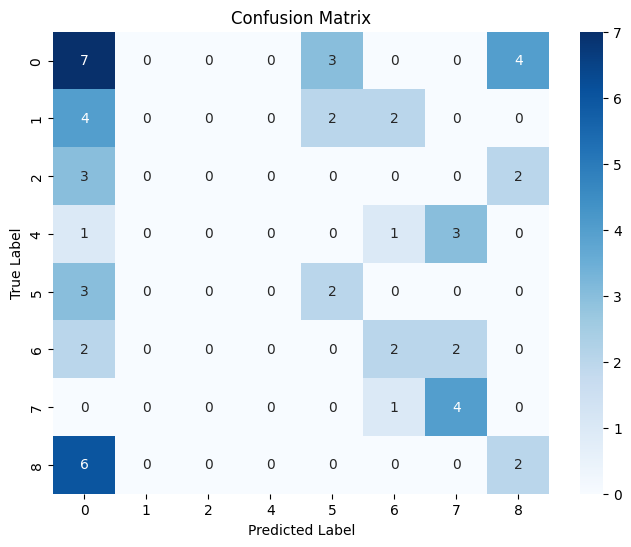

In [17]:
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

mlp = MLPClassifier(hidden_layer_sizes=(100,), random_state=42)

#MLP
mlp.fit(X_train, y_train)

#previsão
y_pred_mlp = mlp.predict(X_test)

acuracia = accuracy_score(y_test, y_pred_mlp)
print("Acurácia:", acuracia)

print("Relatório de Classificação:")
print(classification_report(y_test, y_pred_mlp))

#matriz de confusão
cm = confusion_matrix(y_test, y_pred_bayes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=sorted(y_test.unique()), yticklabels=sorted(y_test.unique()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()




Como já era de se esperar, os resultados foram bem baixos, reduzimos toda a base para apenas duas dimensões, com atributos que já não possuíam tanta correlação com o target escolhido.

_______________________________________________________________________

**Início parte 2**



In [18]:
X = breeds.drop('group', axis=1)


Aqui podemos observar através do método do cotovelo  que o nosso valor ideal de k ficará entre 2 e 4. Então usaremos o coeficiente de silhueta para definir qual k será escolhido

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

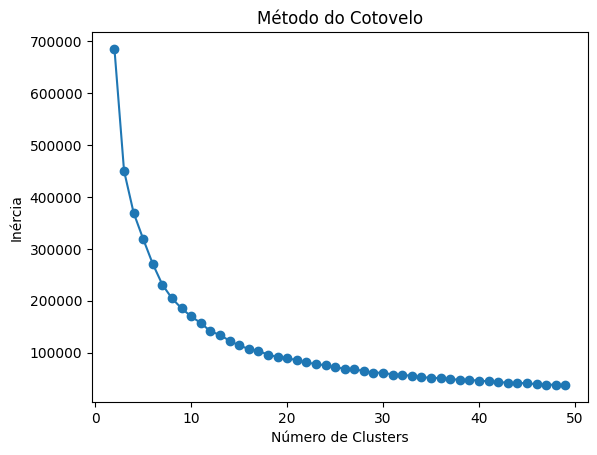

In [19]:
inertia = []

#Variação dos valores de k
for k in range(2, 50):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

#gráfico de cotovelo
plt.plot(range(2, 50), inertia, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo')
plt.show()


Execução do kmeans para os valores de k obtidos

In [20]:
kmeans2 = KMeans(n_clusters=2, random_state=42)
kmeans3 = KMeans(n_clusters=3, random_state=42)

kmeans4 = KMeans(n_clusters=4, random_state=42)

#finalDf é a base com apenas duas dimensões (uso do PCA)
kmeans2.fit(finalDf)
kmeans3.fit(finalDf)
kmeans4.fit(finalDf)

labels2 = kmeans2.labels_
labels3 = kmeans3.labels_
labels4 = kmeans4.labels_


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


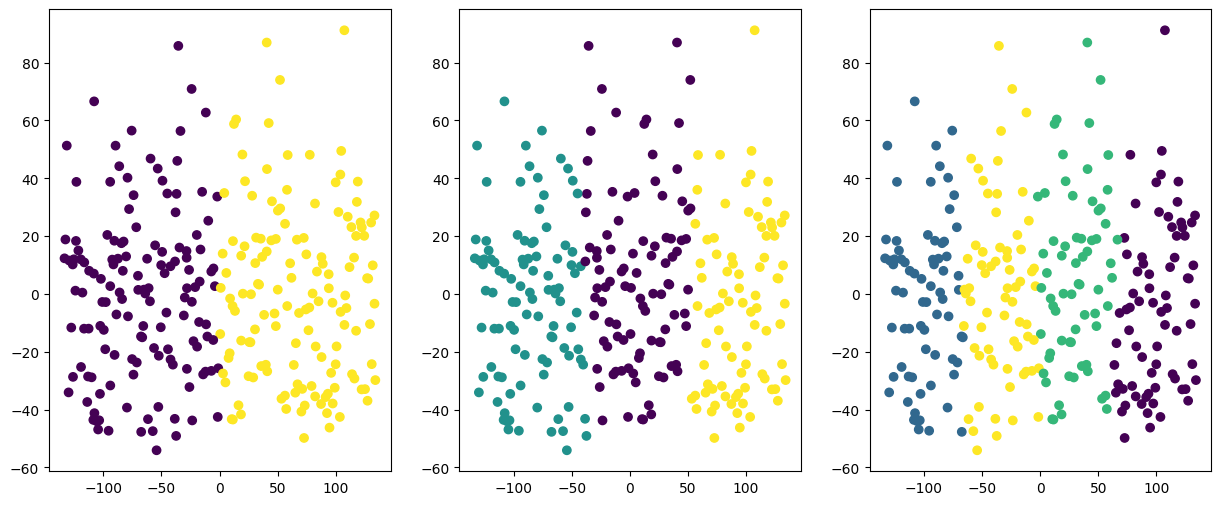

In [21]:
fig, ax = plt.subplots(ncols=3, figsize=(15,6))

ax[0].scatter(finalDf['D1'], finalDf['D2'], c=kmeans2.labels_)

ax[1].scatter(finalDf['D1'], finalDf['D2'], c=kmeans3.labels_)
ax[2].scatter(finalDf['D1'], finalDf['D2'], c=kmeans4.labels_)


plt.show()

Verificação do silhouette_score para o valor de k=2

In [22]:
silhouette_score(X, labels2)


0.5157952232177959

Verificação do silhouette_score para o valor de k=3

In [23]:
silhouette_score(X, labels3)


0.4220570269717729

Verificação do silhouette_score para o valor de k=4

In [24]:
silhouette_score(X, labels4)

0.3424010780987841

Ou seja, o melhor k é o 2.

Agora faremos o modelo hierárquico. Começando, já calculando o valor do número de clusters que obtem o melhor valor do coeficiente de silhueta, que assim como o k-means, o valor é 2.

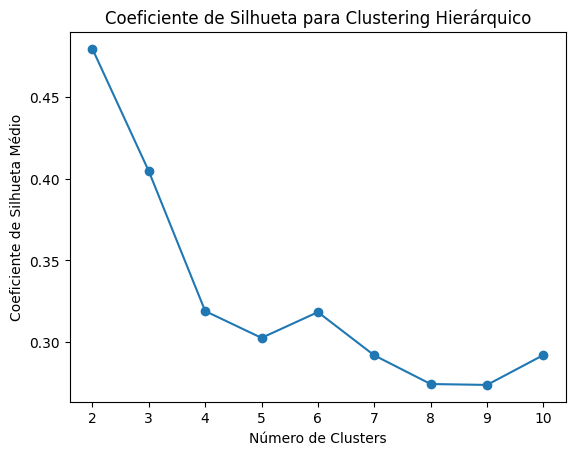

In [25]:
silhouette_avg = []

max_clusters = 10

for k in range(2, max_clusters+1):
    model = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = model.fit_predict(X)
    silhouette_avg.append(silhouette_score(X, labels))

plt.plot(range(2, max_clusters+1), silhouette_avg, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Coeficiente de Silhueta Médio')
plt.title('Coeficiente de Silhueta para Clustering Hierárquico')
plt.show()

Agora, faremos a execução do algoritmo em si, variando entre os métodos do linkage entre ward e complete.

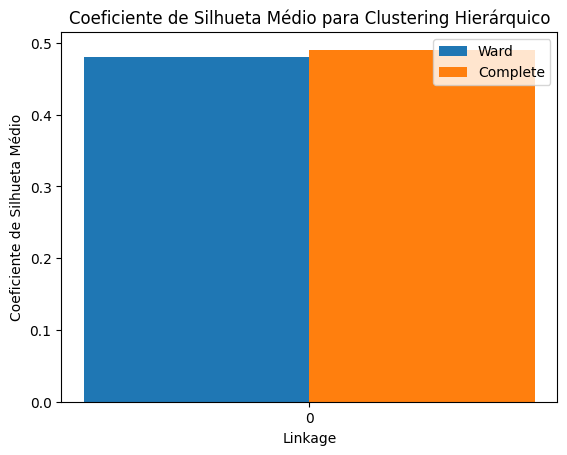

ward:  0.4796237436669352
complete:  0.49030090415704264


In [26]:
# Lista para armazenar valores de coeficiente de silhueta médio
silhouette_avg_ward = []
silhouette_avg_complete = []

# Número de clusters
n_clusters = 2

# Calcular o coeficiente de silhueta médio para linkage='ward'
model_ward = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
labels_ward = model_ward.fit_predict(X)
ward_silhouetter_score = silhouette_score(X, labels_ward)

# Calcular o coeficiente de silhueta médio para linkage='complete'
model_complete = AgglomerativeClustering(n_clusters=n_clusters, linkage='complete')
labels_complete = model_complete.fit_predict(X)
complete_silhouetter_score = silhouette_score(X, labels_complete)

# Plotar gráfico de barras comparando os coeficientes de silhueta médios para 'ward' e 'complete'
x = np.arange(1)
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, ward_silhouetter_score, width, label='Ward')
rects2 = ax.bar(x + width/2, complete_silhouetter_score, width, label='Complete')

ax.set_xlabel('Linkage')
ax.set_ylabel('Coeficiente de Silhueta Médio')
ax.set_title('Coeficiente de Silhueta Médio para Clustering Hierárquico')
ax.set_xticks(x)
ax.legend()

plt.show()

print('ward: ', ward_silhouetter_score)
print('complete: ', complete_silhouetter_score)

Comparando, temos os valores do coeficiente de silhueta do modelo Hieárquico sendo:

*   ward:  0.4796237436669352
*   complete:  0.49030090415704264

Já os valores do coeficiente de silhueta do k-means foi:


*   k-means: 0.5157952232177959





Fim!